In [1]:
import pickle
import torch
import numpy as np
import MF
import math
from sklearn import cluster
from operator import itemgetter
from math import log
import torch.nn as nn
import torch.nn.functional as F
import time
import argparse
import pandas as pd
import utility
from scipy.sparse import csr_matrix, rand as sprand
from tqdm import tqdm
from MF import MF
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


np.random.seed(0)
torch.manual_seed(0)

In [2]:
### Unpickling user and item matrices

test_like = np.load("./data/LFT/user_test_like.npy", allow_pickle=True)
train_like = np.load("./data/LFT/user_train_like.npy", allow_pickle=True)
    
Rec = np.load("./data/LFT/Rec_LFT.npy")

### The test_like and train_like lists, but for item
### test_like_item[I]: the users who like item I in the test set
### train_like_item[I]: the users who like item I in the train set
test_like_item = []
for t in range(Rec.shape[1]):
    test_like_item.append([])
i = 0
for t in test_like:
    for tt in t:
        if type(tt) != type(test_like[0][0]):   ### test_like is not well formatted
            tt = tt[0]
        test_like_item[tt].append(i)
    i += 1

train_like_item = []
for t in range(Rec.shape[1]):
    train_like_item.append([])
i = 0
for t in train_like:
    for tt in t:
        train_like_item[tt].append(i)
    i += 1


In [3]:
###
Rec_train = []

for t in range(Rec.shape[0]):
    row = [0]*Rec.shape[1]
    for item in train_like[t]:
        row[item] = 1
    Rec_train.append(row)
Rec_train = np.array(Rec_train)


J_similar = Rec_train.dot(Rec_train.T)
J_similar = J_similar.astype("float32")

ones = np.ones((Rec_train.shape[0], Rec_train.shape[1]))
tmp = Rec_train + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar - (ones.dot(ones.T))
tmp = sum_mtx - J_similar
J_similar = J_similar/tmp

### Diagonal elements are manually set to 0
for t in range(J_similar.shape[0]):
    J_similar[t][t] = 0



Rec_train_item = Rec_train.T
J_similar_item = Rec_train_item.dot(Rec_train_item.T)
J_similar_item = J_similar_item.astype("float32")

ones = np.ones((Rec_train_item.shape[0], Rec_train_item.shape[1]))
tmp = Rec_train_item + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar_item - (ones.dot(ones.T))
tmp = sum_mtx - J_similar_item
J_similar_item = J_similar_item/tmp
            
for t in range(J_similar_item.shape[0]):
    J_similar_item[t][t] = 0
    
J_similar_item[np.isnan(J_similar_item)] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_61128\942002878.py:35: RuntimeWarning: invalid value encountered in true_divide
  J_similar_item = J_similar_item/tmp


In [4]:
### Functions for metrices
def get_activeness(user):
    return len(train_like[user])

def get_popularity(item):
    return len(train_like_item[item])

def get_user_mainstreamness(user):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar[user])/(J_similar.shape[1]-1))

def get_item_mainstreamness(item):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar_item[item])/(J_similar_item.shape[1]-1))

In [5]:
### Calculate the metrices

activeness = []
user_mainstreamness = []
for t in range(Rec.shape[0]):
    activeness.append(get_activeness(t))
    user_mainstreamness.append((get_user_mainstreamness(t)))
                               
popularity = []
item_mainstreamness = []
for t in range(Rec.shape[1]):
    popularity.append(get_popularity(t))
    item_mainstreamness.append((get_item_mainstreamness(t)))

In [6]:
### _sort[0] = values
### _sort[1] = indexs

act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

act_sort[1].astype("int32")
usrmain_sort[1].astype("int32")
pop_sort[1].astype("int32")
itmmain_sort[1].astype("int32")

array([3462, 3175, 3270, ...,  790,  713,  673])

In [7]:
np.save("./data/LFT/activeness.npy", activeness)
np.save("./data/LFT/user_mainstreamness.npy", user_mainstreamness)
np.save("./data/LFT/popularity.npy", popularity)
np.save("./data/LFT/item_mainstreamness.npy", item_mainstreamness)

np.save("./data/LFT/act_sort.npy", act_sort)
np.save("./data/LFT/usrmain_sort.npy", usrmain_sort)
np.save("./data/LFT/pop_sort.npy", pop_sort)
np.save("./data/LFT/itmmain_sort.npy", itmmain_sort)

np.save("./data/LFT/J_similar.npy", J_similar)
np.save("./data/LFT/J_similar_item.npy", J_similar_item)

In [8]:
### Functions for calculating NDCG@K, performance, and average rank

num_u = Rec.shape[0]
like = train_like
for i in range(num_u):
    Rec[i, like[i]] = -100000.0

### No train set in Rec_sort!!!
### Pretty quick even we sort all users and items
Rec_sort = []
for t in Rec:
    num = t.tolist().count(-100000.0)
    tt = np.argsort(t)[::-1]
    tt = tt[0:(len(tt)-num)]
    Rec_sort.append(tt)

### DG, Rank Sum, Count
DRC = [(0,0)]*Rec.shape[1]


def NDCG_at_k(predicted_list, ground_truth, k):
    dcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(predicted_list[:k])]
    dcg = np.sum(dcg_value)
    if len(ground_truth) < k:
        ground_truth += [0 for i in range(k - len(ground_truth))]
    idcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(ground_truth[:k])]
    idcg = np.sum(idcg_value)
    return dcg / idcg

def get_ndcg_ave(user):
    ###############################################################################################################################
    k_set = [1,5,10,20]
    u_pred = Rec[user, :]
    topk_item_idx_no_train = np.argpartition(u_pred, -k_set[-1])[-k_set[-1]:]
    topk = (np.array([topk_item_idx_no_train, u_pred[topk_item_idx_no_train]])).T
    topk = sorted(topk, key=itemgetter(1), reverse=True)
    new_user_prediction = topk
    test = test_like[user]

    for t in range(len(new_user_prediction)):
        item = new_user_prediction[t]
        DRC[int(item[0])] = ((DRC[int(item[0])][0] + 1/math.log(t+3, 2)), (DRC[int(item[0])][1] + t + 1))
    
    dcg_list = []
    # compute the number of true positive items at top k
    rank_sum = 0
    count = 0
    for i in range(k_set[3]):
        if new_user_prediction[i][0] in test:
            rank_sum += (i+1)
            count += 1
            dcg_list.append(1)
        else:
            dcg_list.append(0)

    # calculate NDCG@k
    idcg_list = [1 for i in range(len(test))]
    ndcg_tmp_15 = NDCG_at_k(dcg_list, idcg_list, k_set[3])
    ### Calculate average rank of test items
    ### Notice: only test items in the top 20 count
    if rank_sum!= 0:
        ave_rank = rank_sum/count
    else:
        ave_rank = 100000
    
    return ndcg_tmp_15, ave_rank


In [9]:
Rec_sort

[array([ 40, 390,  50, ...,  24,  22,   0], dtype=int64),
 array([167,  23,  51, ..., 108, 109,   0], dtype=int64),
 array([127,   5,  48, ..., 204,  44, 176], dtype=int64),
 array([127, 712, 132, ..., 212, 208, 211], dtype=int64),
 array([435, 515, 134, ..., 306, 131, 224], dtype=int64),
 array([171,   5, 116, ..., 407,  64, 409], dtype=int64),
 array([264,  48, 117, ...,  22,  92, 120], dtype=int64),
 array([104, 167,  67, ..., 292, 280, 495], dtype=int64),
 array([244,  38, 259, ...,  50,  51, 514], dtype=int64),
 array([ 64,  26, 739, ..., 186, 692, 616], dtype=int64),
 array([104, 164, 335, ...,  67, 290, 259], dtype=int64),
 array([ 44, 167, 124, ..., 667, 659,   0], dtype=int64),
 array([ 58, 195, 189, ..., 577, 716, 847], dtype=int64),
 array([305, 372, 730, ..., 244,  38, 184], dtype=int64),
 array([ 38,  51, 246, ..., 316, 305,   0], dtype=int64),
 array([878, 332,  69, ..., 287, 940, 929], dtype=int64),
 array([376, 322,  97, ..., 217, 467, 995], dtype=int64),
 array([ 621, 

In [12]:
user_num = Rec.shape[0]
NDCG = []
Ave_rank_user = []
for t in range(user_num):
    ndcg_, ave_rank_ = get_ndcg_ave(t)
    NDCG.append(ndcg_)
    Ave_rank_user.append(ave_rank_)
MDG = []
Ave_rank_item = []
for t in range(len(DRC)):
    count = len(test_like_item[t])
    if count != 0:
        MDG.append(DRC[t][0]/count)
        Ave_rank_item.append(DRC[t][1]/count)
    else:
        MDG.append(0)
        Ave_rank_item.append(0)

NDCG = np.array(NDCG)
Ave_rank_user = np.array(Ave_rank_user)
Performance = np.array(MDG)
Ave_rank_item = np.array(Ave_rank_item)

In [13]:
### New expressions

In [14]:
def get_grouped_users(user, threshold):
    ### Get the users in the same group of the target user
    ### At least 10 users will be returned
    topK = 10
    group = np.argwhere(J_similar[user] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar[user], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp(user):
    ### Threshold for calculating users in the same group
    threshold = 0.03
    old = Rec_train[user]
    group = get_grouped_users(user, threshold)
    group_sim = J_similar[user][group]
    group_exp = Rec_train[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar[user][group])
    if sum != 0:
        new /= np.sum(J_similar[user][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

def get_grouped_items(item, threshold):
    ### Get the users in the same group of the target user
    ### At least 10 users will be returned
    topK = 10
    group = np.argwhere(J_similar_item[item] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar_item[item], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp_item(item):
    ### Threshold for calculating users in the same group
    threshold = 0.03
    old = Rec_train_item[item]
    group = get_grouped_items(item, threshold)
    group_sim = J_similar_item[item][group]
    group_exp = Rec_train_item[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar_item[item][group])
    if sum != 0:
        new /= np.sum(J_similar_item[item][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

In [15]:
new_expression = []
for t in range(Rec_train.shape[0]):
    new_expression.append(new_exp(t))
new_expression = np.array(new_expression)

new_expression_item = []
for t in range(Rec_train_item.shape[0]):
    new_expression_item.append(new_exp_item(t))
new_expression_item = np.array(new_expression_item)

In [16]:
np.save("./data/LFT/new_expression.npy", new_expression)
np.save("./data/LFT/new_expression_item.npy", new_expression_item)

In [17]:
cosine = new_expression.dot(new_expression.T)
l2 = np.sqrt(np.sum(new_expression * new_expression, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

cosine_item = new_expression_item.dot(new_expression_item.T)
l2 = np.sqrt(np.sum(new_expression_item * new_expression_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
cosine_item[np.isnan(cosine_item)] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_61128\2935611253.py:9: RuntimeWarning: invalid value encountered in true_divide
  cosine_item /= l2.dot(l2.T)


In [18]:
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [19]:
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))
act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

In [20]:
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])
    


        
    

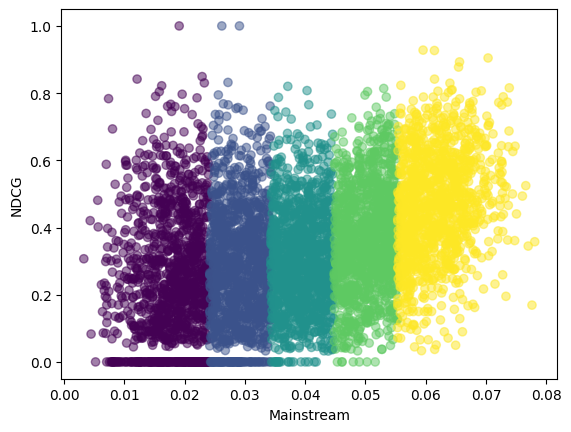

In [21]:
### Convert results to dataframe
### Save the dataframes
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrmain"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrmain"]["Ave_mtc"][group]
    for t in results["usrmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user main.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Mainstream")
plt.show()

In [22]:
df[df["group"] == 0]["NDCG"].mean()

0.2548308173582494

In [23]:
df[df["group"] == 1]["NDCG"].mean()

0.28781593235922787

In [24]:
df[df["group"] == 2]["NDCG"].mean()

0.3051210694234278

In [25]:
df[df["group"] == 3]["NDCG"].mean()

0.3658550423717959

In [26]:
df[df["group"] == 4]["NDCG"].mean()

0.4699428730595898

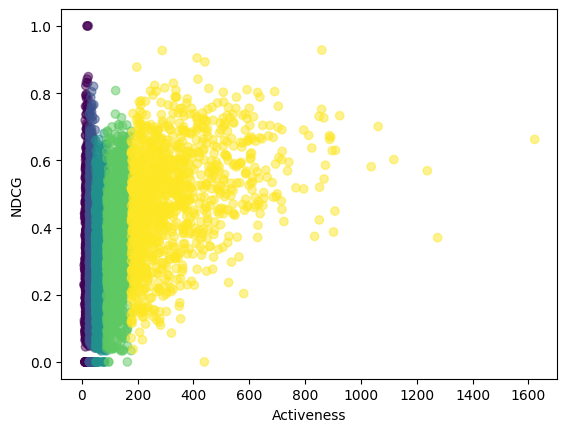

In [32]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["activeness"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["activeness"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["activeness"]["Ave_mtc"][group]
    for t in results["activeness"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user act.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Activeness")
plt.show()

In [33]:
df[df["group"] == 0]["NDCG"].mean()

0.26021456775319496

In [34]:
df[df["group"] == 1]["NDCG"].mean()

0.2916458328551234

In [35]:
df[df["group"] == 2]["NDCG"].mean()

0.29533439236790865

In [36]:
df[df["group"] == 3]["NDCG"].mean()

0.3499046143765937

In [37]:
df[df["group"] == 4]["NDCG"].mean()

0.48646632721947

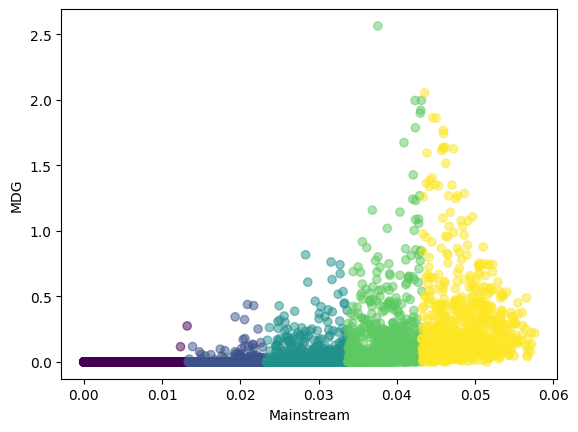

In [27]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmmain"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmmain"]["Ave_mtc"][group]
    for t in results["itmmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item main.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Mainstream")
plt.show()

In [28]:
df[df["group"] == 0]["Performance"].mean()

0.0005631848695883278

In [29]:
df[df["group"] == 1]["Performance"].mean()

0.0075798923059130835

In [30]:
df[df["group"] == 2]["Performance"].mean()

0.04826159426364595

In [31]:
df[df["group"] == 3]["Performance"].mean()

0.1692107874527804

In [32]:
df[df["group"] == 4]["Performance"].mean()

0.2884257961113944

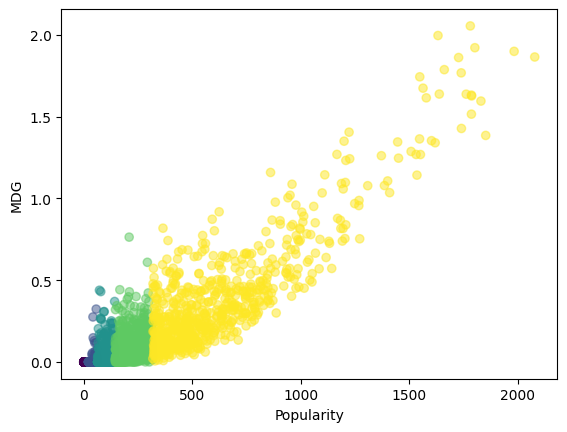

In [33]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["popularity"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["popularity"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["popularity"]["Ave_mtc"][group]
    for t in results["popularity"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item pop.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Popularity")
plt.show()

In [39]:
df[df["group"] == 0]["Performance"].mean()

0.0

In [40]:
df[df["group"] == 1]["Performance"].mean()

0.0026936680653560363

In [41]:
df[df["group"] == 2]["Performance"].mean()

0.026219298703894726

In [42]:
df[df["group"] == 3]["Performance"].mean()

0.0822640440887

In [43]:
df[df["group"] == 4]["Performance"].mean()

0.39689330481977314

In [11]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

IndexError: list index out of range

In [12]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Cosine Mainstreamness")
plt.show()

IndexError: list index out of range

In [7]:
cosine = Rec.dot(Rec.T)
l2 = np.sqrt(np.sum(Rec * Rec, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

Rec_item = Rec.T
cosine_item = Rec_item.dot(Rec_item.T)
l2 = np.sqrt(np.sum(Rec_item * Rec_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
cosine_item[np.isnan(cosine_item)] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_17556\3356049727.py:4: RuntimeWarning: invalid value encountered in true_divide
  cosine = cosine / l2.dot(l2.T)
C:\Users\Zian\AppData\Local\Temp\ipykernel_17556\3356049727.py:10: RuntimeWarning: invalid value encountered in true_divide
  cosine_item /= l2.dot(l2.T)


In [8]:
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [9]:
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))

In [10]:
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])

NameError: name 'NDCG' is not defined

In [ ]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Cosine Mainstreamness")
plt.show()